#### Importing essential libraries

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
import seaborn as sns

#### Reading data

I have used [Netflix](https://finance.yahoo.com/quote/NFLX/history?p=NFLX) stock dataset from Yahoo finance, which contains stock data for the past ten years. 

In the dataset, the “open” column represents the opening price for the stock at that given “date”, and the “close” column is the closing price for that day. The “High” column represents the highest price reached that day, and similarly the “Low” column represents the lowest price. Rest are "closing" price. and "adjusted closing" price


In [124]:
NFLX_stock = pd.read_csv('/content/NFLX.csv')
NFLX_stock.shape

(5082, 7)

In [125]:
NFLX_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


#### Visualizing the Dataset

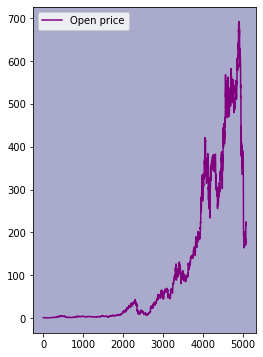

In [126]:
fig, ax = plt.subplots(figsize=(4,6))
ax.set_facecolor('#aaaacc')
plt.plot(NFLX_stock['Open'], color='purple', label='Open price')
plt.legend()
plt.show()

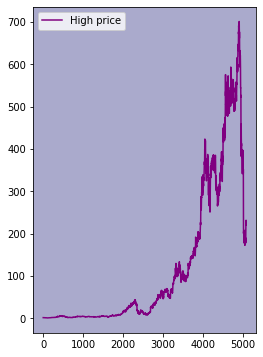

In [127]:
fig, ax = plt.subplots(figsize=(4,6))
ax.set_facecolor('#aaaacc')
plt.plot(NFLX_stock['High'], color='purple', label='High price')
plt.legend()
plt.show()

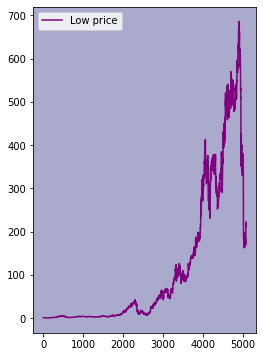

In [128]:
fig, ax = plt.subplots(figsize=(4,6))
ax.set_facecolor('#aaaacc')
plt.plot(NFLX_stock['Low'], color='purple', label='Low price')
plt.legend()
plt.show()

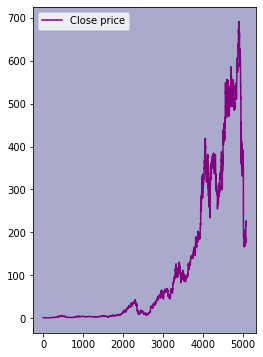

In [129]:
fig, ax = plt.subplots(figsize=(4,6))
ax.set_facecolor('#aaaacc')
plt.plot(NFLX_stock['Close'], color='purple', label='Close price')
plt.legend()
plt.show()

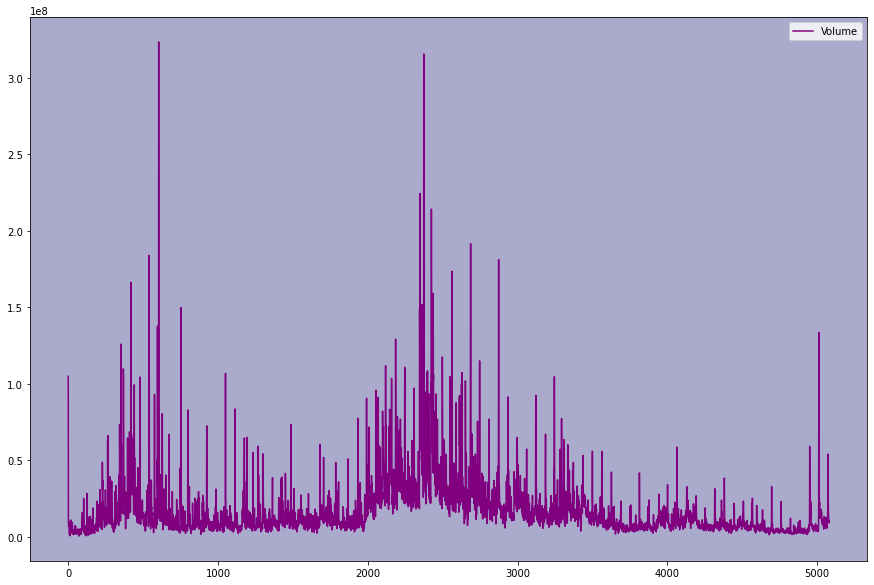

In [130]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_facecolor('#aaaacc')
plt.plot(NFLX_stock['Volume'], color='purple', label='Volume')
plt.legend()
plt.show()

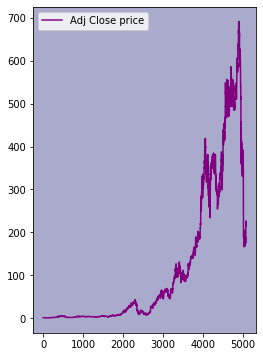

In [131]:
fig, ax = plt.subplots(figsize=(4,6))
ax.set_facecolor('#aaaacc')
plt.plot(NFLX_stock['Adj Close'], color='purple', label='Adj Close price')
plt.legend()
plt.show()

In [132]:
NFLX_stock.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999861,0.999852,0.999690,0.999690,-0.262876
High,0.999861,1.000000,0.999812,0.999860,0.999860,-0.261584
Low,0.999852,0.999812,1.000000,0.999853,0.999853,-0.264345
Close,0.999690,0.999860,0.999853,1.000000,1.000000,-0.262828
Adj Close,0.999690,0.999860,0.999853,1.000000,1.000000,-0.262828
Volume,-0.262876,-0.261584,-0.264345,-0.262828,-0.262828,1.000000


For simplicity I have used only one variable which is the “open” price, because as you see all the values are very much correlated

In [133]:
NFLX_stock = NFLX_stock['Open'].values
NFLX_stock = NFLX_stock.reshape(-1, 1)

In [134]:
NFLX_stock.shape

(5082, 1)

#### Train-Test split of 70%-30%

In [135]:
dataset_train = np.array(NFLX_stock[:int(NFLX_stock.shape[0]*0.8)])
dataset_test = np.array(NFLX_stock[int(NFLX_stock.shape[0]*0.8):])
print("Shape of training dataset: ",dataset_train.shape)
print("Shape of testing dataset: ",dataset_test.shape)

Shape of training dataset:  (4065, 1)
Shape of testing dataset:  (1017, 1)


Using the MinMaxScaler to scale the data between 0 and 1, thus reducing the entire range of values

In [136]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

Creating a helper function to create the datasets, The features (x), contains appended prices from the last 50 days, and for the outcome (y), it is the next price. And then, reshaping the data to make it a 3D array in order to use it in LSTM Layer.


In [137]:
def create_dataset(dataframe):
    x = []
    y = []
    for i in range(75, dataframe.shape[0]):
        x.append(dataframe[i-75:i, 0])

        y.append(dataframe[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y 

x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)



In [138]:
a=x_train
b=y_train
c=x_test
d=y_test

In [139]:
#x_train=a


#### Model

The Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used to process an entire sequence of data. 

Unlike the traditional feed-forward neural network, that passes the values sequentially through each layer of the network, the LSTM network has a feedback connection that remembers preceding information, thus ideal for time-series analysis.

The model used here is a sequential one with 96 units in the output’s dimensionality. I have used return_sequences=True to make the LSTM layer with three-dimensional input and input_shape to shape our dataset.

Using a dropout fraction 0.2 drops 20% of the layers. At the end, I have added a dense layer with a value of 1 because to output one value.




In [140]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

Used the 'mean_squared_error' loss function as it is a regression problem, and the adam optimizer to find optimal weights

In [141]:
model.compile(loss='mse', optimizer='rmsprop')  

In [142]:
model.fit(x_train, y_train, epochs=40, batch_size=32)

Epoch 1/40
125/125 [==============================] - 8s 17ms/step - loss: 0.0039
Epoch 2/40
125/125 [==============================] - 2s 16ms/step - loss: 0.0017
Epoch 3/40
125/125 [==============================] - 2s 16ms/step - loss: 0.0015
Epoch 4/40
125/125 [==============================] - 2s 16ms/step - loss: 0.0013
Epoch 5/40
125/125 [==============================] - 2s 16ms/step - loss: 0.0011
Epoch 6/40
125/125 [==============================] - 2s 16ms/step - loss: 9.7991e-04
Epoch 7/40
125/125 [==============================] - 2s 16ms/step - loss: 8.5469e-04
Epoch 8/40
125/125 [==============================] - 2s 16ms/step - loss: 8.5813e-04
Epoch 9/40
125/125 [==============================] - 2s 16ms/step - loss: 7.3729e-04
Epoch 10/40
125/125 [==============================] - 2s 16ms/step - loss: 7.6950e-04
Epoch 11/40
125/125 [==============================] - 2s 16ms/step - loss: 7.1825e-04
Epoch 12/40
125/125 [==============================] - 2s 16ms/step - lo

Calculating the RMSE to evaluate the final performance

In [143]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

from math import sqrt
sqrt(mean_squared_error(predictions, y_test_scaled))

33.979948397399454

#### Visualizing the output

Checking how well the model has perfomed overall

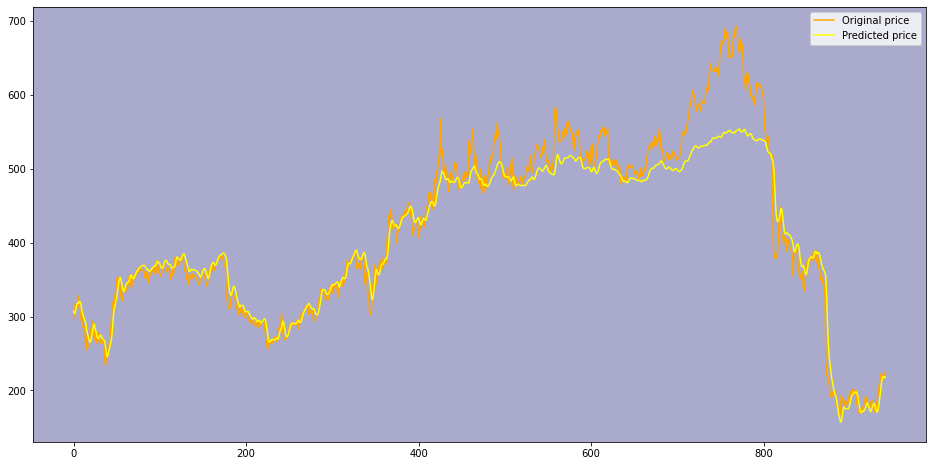

In [144]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#aaaacc')
ax.plot(y_test_scaled, color='orange', label='Original price')
plt.plot(predictions, color='yellow', label='Predicted price')
plt.legend()